In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Load the data
data = pd.read_csv('results.csv',  names=['test case name', 'platform', 'data set size', 'number of repetitions', 'number of repetitions skipped', 'index of repetition', 'total execution time'])
data['platform'] = data['platform'].replace({'sodacore': 'Soda Core', 'greatexpectations': 'Great Expectations', 'expressions': 'Expressions transpiler'})

palette = {'Soda Core': 'cyan', 'Great Expectations': 'orange', 'Expressions transpiler': '#D6006D'}
print(data.head())


  test case name                platform  data set size  \
0     continents  Expressions transpiler          10000   
1     continents  Expressions transpiler          10000   
2     continents  Expressions transpiler          10000   
3     continents  Expressions transpiler          10000   
4     continents  Expressions transpiler          10000   

   number of repetitions  number of repetitions skipped  index of repetition  \
0                     10                              1                   -1   
1                     10                              1                    0   
2                     10                              1                    1   
3                     10                              1                    2   
4                     10                              1                    3   

   total execution time  
0              0.111841  
1              0.025321  
2              0.024941  
3              0.025037  
4              0.025013  


In [3]:
# Check data types
print(data.dtypes)

test case name                    object
platform                          object
data set size                      int64
number of repetitions              int64
number of repetitions skipped      int64
index of repetition                int64
total execution time             float64
dtype: object


In [4]:
data = data[data["index of repetition"] >= 0]

aggregate_data = data.groupby(['test case name','platform', 'data set size']).aggregate(
    mean_execution_time=('total execution time', 'mean'),
    std_deviation=('total execution time', 'std'),
    count=('total execution time', 'count')
).reset_index()

print(aggregate_data.head())

  test case name                platform  data set size  mean_execution_time  \
0     continents  Expressions transpiler          10000             0.024791   
1     continents  Expressions transpiler         100000             0.243883   
2     continents  Expressions transpiler        1000000             2.373286   
3     continents  Expressions transpiler       10000000            24.142718   
4     continents      Great Expectations          10000             0.007251   

   std_deviation  count  
0       0.000283     10  
1       0.002497     10  
2       0.021965     10  
3       0.167391     10  
4       0.000132     10  


In [5]:
import os

os.makedirs('plots', exist_ok=True)
def save_plot(plot, file_name):
    path = os.path.join('plots', file_name) + '.svg'
    plot.savefig(path, dpi=300,  bbox_inches='tight', format="svg")
    
def save_table(table, filename):
    path = os.path.join('plots', filename) + '.tex'
    table.to_latex(path, index=False)

/var/folders/7n/9pr1nk311yb_s9yqf3yjh_500000gp/T/ipykernel_1467/823613803.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(data.dataset_label)


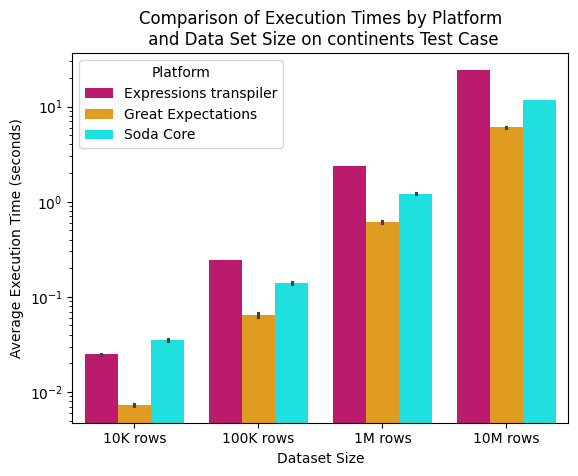

/var/folders/7n/9pr1nk311yb_s9yqf3yjh_500000gp/T/ipykernel_1467/823613803.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(data.dataset_label)


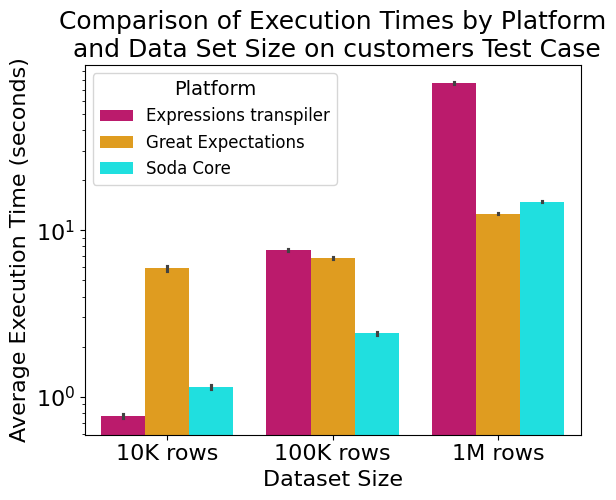

In [6]:
# Create bar plot with 95% confidence intervals

def pretty_print_dataset_size(s):
    # convert 1000 to 1K etc.
    return str(s)[::-1].replace('000000', 'M').replace('000', 'K')[::-1] + ' rows'
    
aggregate_data['dataset_label'] = aggregate_data['data set size'].apply(lambda x: pretty_print_dataset_size(x))


# workaround for seaborn not supporting error bars on bar plots
def barplot_err(x, y, xerr=None, yerr=None, data=None, **kwargs):

    _data = []
    for _i in data.index:

        _data_i = pd.concat([data.loc[_i:_i]]*3, ignore_index=True, sort=False)
        _row = data.loc[_i]
        if xerr is not None:
            _data_i[x] = [_row[x]-_row[xerr], _row[x], _row[x]+_row[xerr]]
        if yerr is not None:
            _data_i[y] = [_row[y]-_row[yerr], _row[y], _row[y]+_row[yerr]]
        _data.append(_data_i)
    

    _data = pd.concat(_data, ignore_index=True, sort=False)

    _ax = sns.barplot(x=x,y=y,data=_data, errorbar=('ci', 95), **kwargs)

    return _ax

test_cases = [ 
              'continents', 
              'customers' 
              ]

# Create a plot for each dataset size
for case in test_cases:
    data = aggregate_data[aggregate_data['test case name'] == case]
    
    table = data.sort_values(by='data set size')
    table.drop(columns=['test case name', 'count', 'data set size'], inplace=True)
    table.rename(columns={'dataset_label': 'data set', "mean_execution_time": "mean execution time (s)", "std_deviation": "standard deviation (s)"}, inplace=True)
    table = table[['data set'] + [col for col in table if col != 'data set']]

    save_table(table, 'execution_time_comparison_' + case)
    
    
    plt.plot(figsize=(14,10))
    chart = barplot_err(x="data set size", y="mean_execution_time", yerr="std_deviation", hue="platform", palette=palette,
    data=data, ax=plt.gca())
    chart.set_xticklabels(data.dataset_label)

    plt.yscale('log')
    plt.title('Comparison of Execution Times by Platform\n and Data Set Size on ' + case + ' Test Case')
    plt.xlabel('Dataset Size')
    plt.ylabel('Average Execution Time (seconds)')
    plt.legend(title='Platform')
    plt.rcParams.update({
    'font.size': 14,        # General font size
    'axes.titlesize': 18,   # Font size of the title of the axes
    'axes.labelsize': 16,   # Font size of the x and y labels
    'xtick.labelsize': 16,  # Font size of the x-tick labels
    'ytick.labelsize': 16,  # Font size of the y-tick labels
    'legend.fontsize': 12,  # Font size of the legend
    'figure.titlesize': 26  # Font size of the figure title
})
    save_plot(plt, 'execution_time_comparison_' + case)
    plt.rcParams.update({
    'font.size': 14,        # General font size
    'axes.titlesize': 18,   # Font size of the title of the axes
    'axes.labelsize': 16,   # Font size of the x and y labels
    'xtick.labelsize': 16,  # Font size of the x-tick labels
    'ytick.labelsize': 16,  # Font size of the y-tick labels
    'legend.fontsize': 12,  # Font size of the legend
    'figure.titlesize': 26  # Font size of the figure title
})
    plt.show()

/var/folders/7n/9pr1nk311yb_s9yqf3yjh_500000gp/T/ipykernel_1467/258282795.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['relative_speedup'] = plot_data.apply(calculate_relative_speedup, axis=1, args=(base_times,))
/var/folders/7n/9pr1nk311yb_s9yqf3yjh_500000gp/T/ipykernel_1467/258282795.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(plot_data.dataset_label)


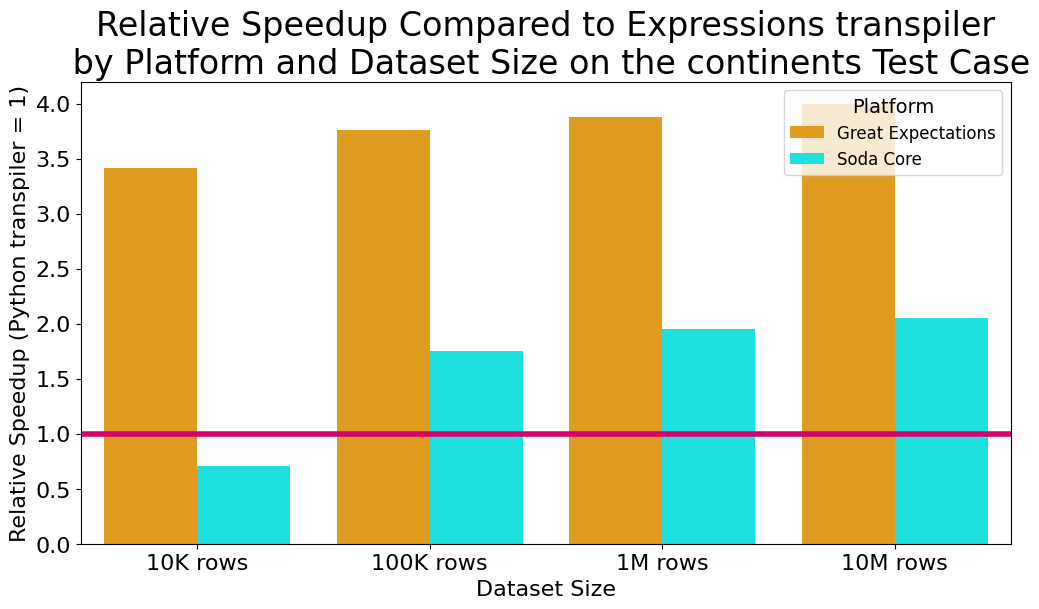

/var/folders/7n/9pr1nk311yb_s9yqf3yjh_500000gp/T/ipykernel_1467/258282795.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data['relative_speedup'] = plot_data.apply(calculate_relative_speedup, axis=1, args=(base_times,))
/var/folders/7n/9pr1nk311yb_s9yqf3yjh_500000gp/T/ipykernel_1467/258282795.py:31: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  chart.set_xticklabels(plot_data.dataset_label)


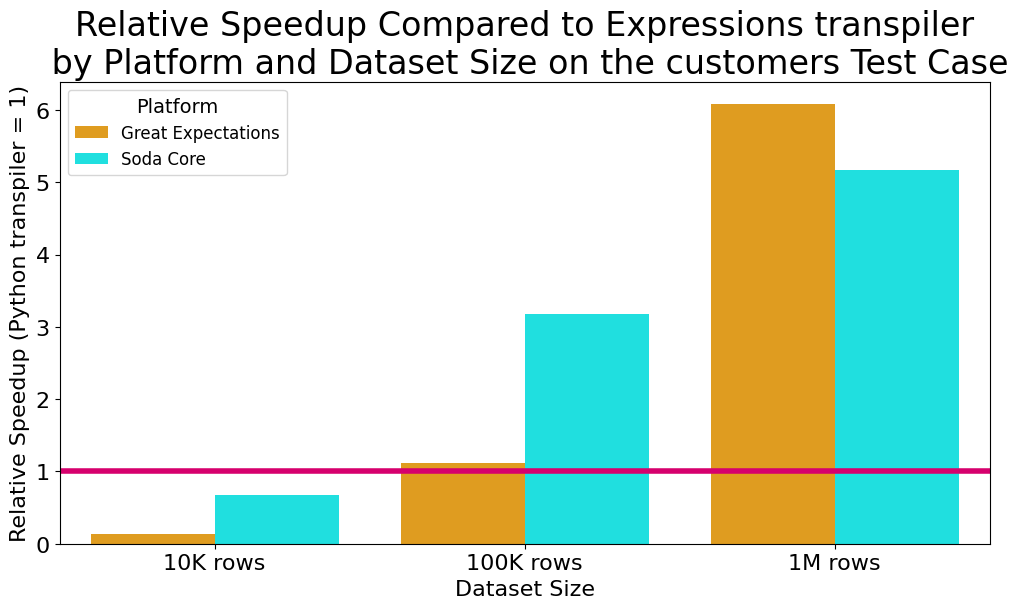

In [7]:
def calculate_relative_speedup(row, base_times):
    base_time = base_times.get(row['data set size'])
    if base_time is not None:
        speedup = base_time / row['mean_execution_time']
        return speedup
    return np.nan 

base_platform = 'Expressions transpiler'
test_cases = [ 'continents', 'customers' ]

# Create a plot and a table for each dataset size
for case in test_cases:
        
    plot_data = aggregate_data[aggregate_data['test case name'] == case]
    base_times = plot_data[plot_data['platform'] == base_platform].set_index('data set size')['mean_execution_time']
    plot_data['relative_speedup'] = plot_data.apply(calculate_relative_speedup, axis=1, args=(base_times,))
    plot_data = plot_data[plot_data['platform'] != base_platform]
     
    table = plot_data.sort_values(by='data set size')
    table.drop(columns=['test case name', 'count', 'data set size', 'mean_execution_time', "std_deviation"], inplace=True)
    table.rename(columns={'dataset_label': 'data set', "relative_speedup": "speedup relative to the Python transpiler"}, inplace=True)
    table = table[['data set'] + [col for col in table if col != 'data set']]
    save_table(table, 'relative_time_comparison_' + case)
   
    plt.figure(figsize=(12, 6))
    chart = sns.barplot(data=plot_data, x='data set size', y='relative_speedup', hue='platform', palette=palette)
    plt.title(f"Relative Speedup Compared to {base_platform}\n by Platform and Dataset Size on the {case} Test Case",  fontsize=24)
    plt.ylabel('Relative Speedup (Python transpiler = 1)')
    plt.xlabel('Dataset Size')
    plt.axhline(1, color='#D6006D', linewidth=4)
    chart.set_xticklabels(plot_data.dataset_label)  
    plt.legend(title='Platform')
    plt.rcParams.update({
    'font.size': 14,        # General font size
    'axes.titlesize': 12,   # Font size of the title of the axes
    'axes.labelsize': 16,   # Font size of the x and y labels
    'xtick.labelsize': 16,  # Font size of the x-tick labels
    'ytick.labelsize': 16,  # Font size of the y-tick labels
    'legend.fontsize': 12,  # Font size of the legend
    'figure.titlesize': 64  # Font size of the figure title
})
    save_plot(plt, 'relative_speedup_comparison_' + case)
    plt.rcParams.update({
    'font.size': 14,        # General font size
    'axes.titlesize': 18,   # Font size of the title of the axes
    'axes.labelsize': 16,   # Font size of the x and y labels
    'xtick.labelsize': 16,  # Font size of the x-tick labels
    'ytick.labelsize': 16,  # Font size of the y-tick labels
    'legend.fontsize': 12,  # Font size of the legend
    'figure.titlesize': 64  # Font size of the figure title
})
    plt.show()


